In [29]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [30]:
%matplotlib inline
from matplotlib import pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (6.0, 4.0) # this controls figure size in the notebook

SEED = 42 # 42 is the seed used by us for the experiments
PATCH_SIZE = 8 # Pixel side size of the patches
EXAMPLE_SIZE = 256 # Pixel side size of the examples

In [31]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zaraks/pascal-voc-2007")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Nicolò\.cache\kagglehub\datasets\zaraks\pascal-voc-2007\versions\1


In [32]:
import os
from PIL import Image # we use PIL due to problems with cv2 for opening images due to unicode present in path
import random
import numpy

def generate_patch(path, height, width, verbose=False, seed=None):
    """
    Generate a height x width greyscale patch from a random
    image sampled from the ones in the given path

    Args:
        path (str): location of image (.png or .jpg) dataset
        height (int): height of patch, must be positive
        width (int): width of patch, must be positive
        verbose (bool): whether to print how many images can be used to generate patches
        seed (int): the seed to be used for the random number generator

    Returns:
        Image: generated patch, or None if height or width are invalid
    """
    
    if (height<1 or width<1):
        print("invalid height or width, they must be positive")
        return None
    
    # Sets seed
    random.seed(seed)
    
    # List all image files in the directory, sorted to make it deterministic
    image_files = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')])

    # Filter images based on size
    valid_images = []
    for image_file in image_files:
        with Image.open(image_file) as img:
            if img.size[0] >= width and img.size[1] >= height:
                valid_images.append(image_file)

    if len(valid_images)<1 :
        print(f"No valid images found")
        return None
    
    if verbose:
        print(f"Found {len(valid_images)} valid images")

    # Select a random image from the valid images
    random_image = random.choice(valid_images)
 
     # Open the selected image
    with Image.open(random_image) as img:
        # Convert image to greyscale
        img = img.convert("L")
        # Generate a random patch
        x = random.randint(0, img.size[0] - width)
        y = random.randint(0, img.size[1] - height)
        patch = img.crop((x, y, x + width, y + height))
    
    
    return patch

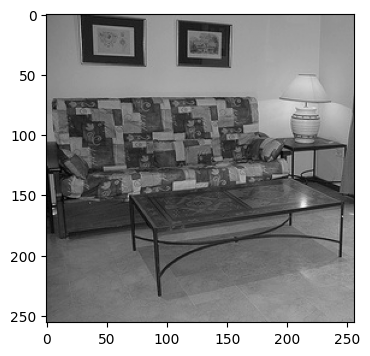

In [33]:
# Let's generate a patch and plot it to check the correctness of the function

patch = generate_patch(path + "/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages", 
                       EXAMPLE_SIZE, EXAMPLE_SIZE, seed=SEED)

plt.imshow(patch,"grey")

In [34]:
def generate_patches(path, height, width, num_patches, verbose=False, seed=None):
    """
    Generate n height x width greyscale patches from random
    images sampled from the ones in the given path

    Args:
        path (str): location of image (.png or .jpg) dataset
        height (int): height of patch, must be positive
        width (int): width of patch, must be positive
        num_patches (int): number of patches you want to generate
        verbose (bool): whether to print how many images can be used to generate patches
        seed (int): the seed to be used for the random number generator

    Returns:
        NDarray[NDarray]: numpy array of generated patches in the format needed by 
                        MiniBatchDictionaryLearning, or None if height or width are invalid
    """
    
    if (height<1 or width<1):
        print("invalid height or width, they must be positive")
        return None
    
    # Sets seed
    random.seed(seed)
    
    # List all image files in the directory, sorted to make it deterministic
    image_files = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg') 
                          or f.endswith('.png')])

    # Filter images based on size
    valid_images = []
    for image_file in image_files:
        with Image.open(image_file) as img:
            if img.size[0] >= width and img.size[1] >= height:
                valid_images.append(image_file)

    if len(valid_images)<1 :
        print(f"No valid images found")
        return None
    
    if verbose:
        print(f"Found {len(valid_images)} valid images")

    
    # Initialize an array to store patches
    patches = numpy.empty((num_patches,height*width), dtype=numpy.uint8)
    for i in range(num_patches):
        # Select a random image from the valid images
        random_image = random.choice(valid_images)
        with Image.open(random_image) as img:
            # Convert image to greyscale
            img = img.convert("L")
            # Generate a random patch
            x = random.randint(0, img.size[0] - width)
            y = random.randint(0, img.size[1] - height)
            patch = img.crop((x, y, x + width, y + height))
            patches[i]=numpy.array(patch).flatten()

    return patches

In [ ]:
import concurrent.futures

# Function to generate multiple patches within a worker thread
def extract_patches(worker_id, images_subset, num_patches, height, width, seed):
    try:
        # Unique seed for each worker
        random.seed(seed + worker_id)  
        numpy.random.seed(seed + worker_id)

        # Initialize an array to store patches
        patches = numpy.empty((num_patches,height*width), dtype=numpy.uint8)
        
        for i in range(num_patches):
            # Select a random image from the valid images
            random_image = random.choice(images_subset)
            with Image.open(random_image) as img:
                # Convert to grayscale
                img = img.convert("L")  
                # Generate a random patch
                x = random.randint(0, img.size[0] - width)
                y = random.randint(0, img.size[1] - height)
                patch = img.crop((x, y, x + width, y + height))
                patches[i]=numpy.array(patch).flatten()

        return patches

    except Exception as e:
        # Return an empty array instead of crashing
        print(f"Worker {worker_id} failed: {e}")
        return numpy.empty((0, height * width), dtype=numpy.uint8)  

def generate_patches_concurrent(path, height, width, n, verbose=False, seed=None, num_workers=12):
    """
    Generate n height x width greyscale patches from random
    images sampled from the ones in the given path in a concurrent manner

    Args:
        path (str): location of image (.png or .jpg) dataset
        height (int): height of patch, must be positive
        width (int): width of patch, must be positive
        n (int): number of patches you want to generate
        verbose (bool): whether to print how many images can be used to generate patches
        seed (int): the seed to be used for the random number generator
        num_workers (int): number of threads you want to use

    Returns:
        NDarray[NDarray]: numpy array of generated patches in the format needed by 
                        MiniBatchDictionaryLearning, or None if height or width are invalid
    """

    if height < 1 or width < 1:
        print("Invalid height or width, they must be positive")
        return None

    # Sets seed
    random.seed(seed)

    # List all image files in the directory, sorted to make it deterministic
    image_files = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')])

    # Filter images based on size
    valid_images = [img for img in image_files if Image.open(img).size[0] >= width and Image.open(img).size[1] >= height]

    if len(valid_images) < 1:
        print(f"No valid images found")
        return None

    if verbose:
        print(f"Found {len(valid_images)} valid images")

    # Divide images fairly among workers
    image_chunks = numpy.array_split(valid_images, num_workers)
    num_patches_per_worker = n // num_workers

    # Initialize empty array to store patches
    patches = numpy.empty((n, height * width), dtype=numpy.uint8)

    # Run parallel execution with ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {
            executor.submit(extract_patches, i, image_chunks[i], num_patches_per_worker, 
                            height, width, seed): i
            for i in range(num_workers)
        }

        # Collect results and merge into final patches array
        start_idx = 0
        for future in concurrent.futures.as_completed(futures):
            worker_patches = future.result()

            # Ensure worker returned valid patches before assigning
            if worker_patches.shape[0] > 0:
                patches[start_idx:start_idx + worker_patches.shape[0]] = worker_patches
                start_idx += worker_patches.shape[0]

    return patches


In [36]:
from sklearn.decomposition import MiniBatchDictionaryLearning

dataset=generate_patches_concurrent(path + "/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages", 
                         PATCH_SIZE, PATCH_SIZE, 10**2, False, seed=SEED)

# Check the shape of the dataset
print(dataset.shape)

# train the dictionary
model = MiniBatchDictionaryLearning(alpha=1, max_iter=1000, n_jobs=-1, fit_algorithm='lars', 
                                   batch_size=256, random_state=SEED)
model.fit(dataset)

(100, 64)


MiniBatchDictionaryLearning(n_jobs=-1, random_state=42)

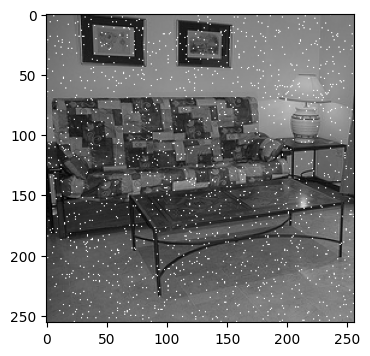

In [37]:
# let us make a noisy image 
import cv2
def add_gaussian_noise(image, mean=0, std=0.5, seed=None):
    """
    Add Gaussian noise to an image.
    
    Args:
        image (NDarray): the input image in the format cv2 uses
        mean (float): the mean of the Gaussian noise
        std (float): the standard deviation of the Gaussian noise
        seed (int): the seed to be used for the random number generator 
    
    Returns:
        NDarray: the image with the added Gaussian noise
    """
    # Sets the seed
    numpy.random.seed(seed)

    # Generate Gaussian noise
    gaussian_noise = numpy.random.normal(mean, std, image.shape).astype('uint8')
    
    # Add the Gaussian noise to the image
    noisy_image = cv2.add(image, gaussian_noise)
    
    return noisy_image

noisy_patch = add_gaussian_noise(numpy.array(patch), seed=SEED)
plt.imshow(noisy_patch, cmap='gray')

(65536, 8, 8)


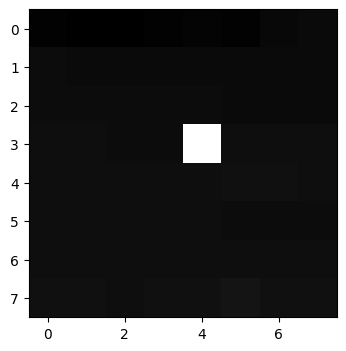

In [38]:
# Extract patches centered on each pixel

def extract_all_centered_patches(image, height, width):
    """
    Extracts a patch centered at each pixel in the image.
    
    Args:
        image (NDarray): Input image as a 2D array.
        height (int): Height of the patch.
        width (int): Width of the patch.
    
    Returns:
        NDarray[NDarray[NDarray]]: Array containing all the extracted patches
    """
    
    H, W = image.shape
    
    # Calculate half sizes
    h_half = height // 2
    w_half = width // 2
    
    # Pad the image to handle border pixels
    padded_img = cv2.copyMakeBorder(image, h_half, h_half, w_half, w_half, 
                                    borderType=cv2.BORDER_REFLECT) 
    # Border reflect was used due to it seemingly being common practice
    
    # Initialize an array to hold the patches
    patches = numpy.empty((H*W, height, width), dtype=image.dtype)
    
    # Loop over each pixel position in the original image
    for i in range(H):
        for j in range(W):
            patch = padded_img[i: i + height, 
                               j: j + width]
            patches[i*W+j] = patch
    
    return patches


extracted_patches=extract_all_centered_patches(noisy_patch, PATCH_SIZE, PATCH_SIZE)
print(extracted_patches.shape)
plt.imshow(extracted_patches[12345],cmap="grey")

In [40]:
import time
def block_matching_similar_patches(patches, height, width, xi, w):
    """
    Given an array of patches extracted from an image and a threshold xi,
    performs block matching within a window of size w x w for each patch.
    
    Args:
        patches (NDarray): Array of extracted patches from extract_all_centered_patches()
        height (int): Height of the original image.
        width (int): Width of the original image.
        xi (float): Threshold for the squared Euclidean distance.
        w (int): Size of the search window (w x w).
        
    Returns:
        similar_patches (list): A list containing for every pixel in the original imagean array 
                                containing the patches similar to the patch centered on that pixel.
    """
    n, _, _ = patches.shape

    # initialize list to store the similar patches for each pixel
    similar_patches = [None] * n  
    
    # Pre-compute vectorized patches for fast distance computation
    patches_vec = patches.reshape(n, -1)

    w_half = w // 2

    # Precompute row and col indices
    row_indices = numpy.arange(height).repeat(width)
    col_indices = numpy.tile(numpy.arange(width), height)

    for i in range(n):
        row, col = row_indices[i], col_indices[i]

        # Define window boundaries
        r_min, r_max = max(0, row - w_half), min(height - 1, row + w_half)
        c_min, c_max = max(0, col - w_half), min(width - 1, col + w_half)

        # Get the indices for patches within the window.
        r_grid, c_grid = numpy.meshgrid(numpy.arange(r_min, r_max + 1), 
                                        numpy.arange(c_min, c_max + 1), indexing='ij')
        candidate_indices = (r_grid * width + c_grid).ravel()

        # Compute squared Euclidean distances
        patch_current = patches_vec[i]
        candidates = patches_vec[candidate_indices]
        dists = numpy.sum((candidates - patch_current) ** 2, axis=1)

        # Filter patches based on threshold
        similar_patches[i] = patches[candidate_indices[dists <= xi]]

    return similar_patches

xi = (128 ** 2) / (PATCH_SIZE**2)  # TODO tuning
start_time = time.time()
similar_patches = block_matching_similar_patches(extracted_patches, EXAMPLE_SIZE, EXAMPLE_SIZE, xi, 64)
end_time = time.time()
print(f"Execution Time (xi=128^2): {end_time - start_time:.2f} seconds")
print(similar_patches[22000].size / PATCH_SIZE**2)

xi = (256 ** 2) / (PATCH_SIZE**2)  # TODO tuning
start_time = time.time()
similar_patches = block_matching_similar_patches(extracted_patches, EXAMPLE_SIZE, EXAMPLE_SIZE, xi, 64)
end_time = time.time()
print(f"Execution Time (xi=256^2): {end_time - start_time:.2f} seconds")
print(similar_patches[22000].size / PATCH_SIZE**2)

xi = (512 ** 2) / (PATCH_SIZE**2)  # TODO tuning
start_time = time.time()
similar_patches = block_matching_similar_patches(extracted_patches, EXAMPLE_SIZE, EXAMPLE_SIZE, xi, 64)
end_time = time.time()
print(f"Execution Time (xi=512^2): {end_time - start_time:.2f} seconds")
print(similar_patches[22000].size / PATCH_SIZE**2)

Execution Time (xi=128^2): 43.44 seconds
2.0
Execution Time (xi=256^2): 40.10 seconds
34.0
Execution Time (xi=512^2): 43.40 seconds
338.0


In [46]:
def process_patch_batch(start_idx, end_idx, patches, patches_vec, xi, neighbor_indices):
    """
    Process a batch of patches to find similar patches within the search window.
    """
    results = {}

    for i in range(start_idx, end_idx):
        candidate_indices = neighbor_indices[i]
        
        # Compute squared Euclidean distances in a vectorized manner
        patch_current = patches_vec[i]
        candidates = patches_vec[candidate_indices]
        dists = numpy.sum((candidates - patch_current) ** 2, axis=1)

        # Select patches within the threshold
        results[i] = patches[candidate_indices[dists <= xi]]

    return results


def precompute_neighbor_indices(height, width, w):
    """
    Precompute the indices of all neighboring patches within the window for each pixel.
    """
    n = height * width
    w_half = w // 2
    row_indices = numpy.arange(height).repeat(width)
    col_indices = numpy.tile(numpy.arange(width), height)
    neighbor_indices = []

    for i in range(n):
        row, col = row_indices[i], col_indices[i]

        # Define window boundaries
        r_min, r_max = max(0, row - w_half), min(height - 1, row + w_half)
        c_min, c_max = max(0, col - w_half), min(width - 1, col + w_half)

        # Generate candidate indices within the window
        r_grid, c_grid = numpy.meshgrid(numpy.arange(r_min, r_max + 1), numpy.arange(c_min, c_max + 1),
                                         indexing='ij')
        neighbor_indices.append((r_grid * width + c_grid).ravel())

    return numpy.array(neighbor_indices, dtype=object)


def block_matching_similar_patches_concurrent(patches, height, width, xi, w, num_workers=12):
    """
    Given an array of patches extracted from an image and a threshold xi,
    performs block matching within a window of size w x w for each patch.
    
    Args:
        patches (NDarray): Array of extracted patches from extract_all_centered_patches()
        height (int): Height of the original image.
        width (int): Width of the original image.
        xi (float): Threshold for the squared Euclidean distance.
        w (int): Size of the search window (w x w).
        num_workers (int): number of threads you want to use
        
    Returns:
        similar_patches (list): A list containing for every pixel in the original imagean array 
                                containing the patches similar to the patch centered on that pixel.
    """
    n, _, _ = patches.shape
    patches_vec = patches.reshape(n, -1)

    # Precompute neighbor indices for all patches
    neighbor_indices = precompute_neighbor_indices(height, width, w)

    # Initialize list to store results
    similar_patches = [None] * n

    # Divide patches into chunks
    chunk_size = max(1, n // num_workers)
    chunks = [(i, min(i + chunk_size, n)) for i in range(0, n, chunk_size)]

    # Use ThreadPoolExecutor to process batches in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {
            executor.submit(process_patch_batch, start, end, patches, patches_vec, 
                            xi, neighbor_indices): (start, end)
            for start, end in chunks
        }

        # Collect results
        for future in concurrent.futures.as_completed(futures):
            batch_results = future.result()
            for i, result in batch_results.items():
                similar_patches[i] = result

    return similar_patches

xi = (128 ** 2) / (PATCH_SIZE**2)  # TODO tuning
start_time = time.time()
similar_patches = block_matching_similar_patches_concurrent(extracted_patches, EXAMPLE_SIZE, EXAMPLE_SIZE, xi, 64)
end_time = time.time()
print(f"Execution Time (xi=128^2): {end_time - start_time:.2f} seconds")
print(similar_patches[22000].size / PATCH_SIZE**2)

xi = (256 ** 2) / (PATCH_SIZE**2)  # TODO tuning
start_time = time.time()
similar_patches = block_matching_similar_patches_concurrent(extracted_patches, EXAMPLE_SIZE, EXAMPLE_SIZE, xi, 64)
end_time = time.time()
print(f"Execution Time (xi=256^2): {end_time - start_time:.2f} seconds")
print(similar_patches[22000].size / PATCH_SIZE**2)

xi = (512 ** 2) / (PATCH_SIZE**2)  # TODO tuning
start_time = time.time()
similar_patches = block_matching_similar_patches_concurrent(extracted_patches, EXAMPLE_SIZE, EXAMPLE_SIZE, xi, 64)
end_time = time.time()
print(f"Execution Time (xi=512^2): {end_time - start_time:.2f} seconds")
print(similar_patches[22000].size / PATCH_SIZE**2)

Execution Time (xi=128^2): 28.91 seconds
2.0
Execution Time (xi=256^2): 18.06 seconds
34.0
Execution Time (xi=512^2): 28.30 seconds
338.0


In [ ]:
def group_lasso_solver(Y, D, epsilon, lam, max_iter=100, tol=1e-4):
    """
    Solves for the coefficients A for a group S of patches using a proximal
    gradient method for the group Lasso problem:
    
      minimize   (1/|S|) sum_k ||A(k,:)||_2 + (lambda/2)||Y - D A||_F^2
      subject to  ||Y - D A||_F^2 <= epsilon
    
    Here Y is of shape (m, |S|) and D is of shape (m, K). 
    This formulation is a penalized version that approximately enforces the constraint.
    
    Args:
        Y (NDarray): Data matrix for group S, shape (m, s)
        D (NDarray): Current dictionary, shape (m, K)
        epsilon (float): Tolerance on the reconstruction error.
        lam (float): Regularization parameter.
        max_iter (int): Maximum number of iterations.
        tol (float): Tolerance for convergence.
        
    Returns:
        A (NDarray): Coefficient matrix for group S, shape (K, s)
    """
    m, s = Y.shape
    _, K = D.shape
    A = np.zeros((K, s))
    # Set step size (could use Lipschitz constant estimation)
    L = np.linalg.norm(D, ord=2)**2  # Lipschitz constant for D^T D
    t = 1.0 / L
    
    for it in range(max_iter):
        # Gradient step: gradient of (lambda/2)||Y-D A||_F^2 w.r.t. A
        grad = - D.T @ (Y - D @ A) * lam
        A_next = A - t * grad
        
        # Proximal operator for group Lasso: for each row
        for k in range(K):
            norm_row = np.linalg.norm(A_next[k, :])
            thresh = t / (s)  # note: 1/|S| weight; adjust t if needed
            if norm_row > thresh:
                A_next[k, :] = (1 - thresh / norm_row) * A_next[k, :]
            else:
                A_next[k, :] = 0.
                
        # Check convergence
        if np.linalg.norm(A_next - A) < tol:
            break
        A = A_next.copy()
        
    # (Optional) if reconstruction error > epsilon, one might increase lam.
    return A

def update_dictionary(Y_list, A_list, D, max_iter=50, tol=1e-4):
    """
    Updates the dictionary D given a set of groups of patches Y and their coefficients A.
    
    Args:
        Y_list (list): List of np.ndarray; each Y is shape (m, s_i) for group i.
        A_list (list): List of np.ndarray; each A is shape (K, s_i) for group i.
        D (NDarray): Current dictionary, shape (m, K).
        max_iter (int): Maximum iterations for dictionary update.
        tol (float): Tolerance for convergence.
        
    Returns:
        D_new (NDarray): Updated dictionary with unit ℓ2 columns.
    """
    m, K = D.shape
    # Aggregate gradient over all groups:
    grad = np.zeros_like(D)
    total_error = 0.0
    total_count = 0
    for Y, A in zip(Y_list, A_list):
        err = Y - D @ A
        grad += - err @ A.T
        total_error += np.linalg.norm(err, 'fro')**2
        total_count += 1
    # A simple gradient descent step
    step = 1e-3  # step size, may need tuning
    D_new = D - step * grad
    # Project each column to unit norm
    for k in range(K):
        D_new[:, k] /= max(np.linalg.norm(D_new[:, k]), 1e-8)
    return D_new

def solve_equation8(groups, initial_D, epsilon_list, lam=0.1, n_outer=10):
    """
    Solve Equation (8) using alternating minimization.
    
    Args:
        groups (list): List of groups. Each element is a tuple (Y, indices) where
                       Y is the matrix of patches for that group (each column a patch,
                       shape (m, s_i)), and indices is an optional identifier.
        initial_D (NDarray): Initial dictionary, shape (m, K)
        epsilon_list (list): List of epsilon_i for each group.
        lam (float): Regularization parameter for group sparse coding.
        n_outer (int): Number of alternating iterations.
        
    Returns:
        D (NDarray): Learned dictionary.
        A_groups (list): List of coefficient matrices for each group.
    """
    D = initial_D.copy()
    A_groups = [None] * len(groups)
    
    for outer in range(n_outer):
        Y_list = []
        # Sparse coding step: For each group solve for A_i
        for i, (Y, _) in enumerate(groups):
            epsilon_i = epsilon_list[i]
            # Y has shape (m, s_i)
            A = group_lasso_solver(Y, D, epsilon_i, lam)
            A_groups[i] = A
            Y_list.append(Y)
        # Dictionary update step: update D using all groups
        D = update_dictionary(Y_list, A_groups, D)
        # (Optional) monitor overall error:
        total_err = 0.0
        for i, (Y, _) in enumerate(groups):
            err = np.linalg.norm(Y - D @ A_groups[i], 'fro')**2
            total_err += err
        print(f'Iteration {outer}, total reconstruction error: {total_err:.4f}')
    return D, A_groups

In [ ]:
def prepare_group_Y(similar_patches_group):
    """
    Given an array of similar patches of shape (h, patch_height, patch_width),
    returns a data matrix Y of shape (patch_height * patch_width, h)
    where each column is a vectorized patch.
    
    Args:
        similar_patches_group (NDarray): Array of shape (h, ph, pw)
        
    Returns:
        Y (NDarray): 2D data matrix of shape (ph*pw, h)
    """
    h, ph, pw = similar_patches_group.shape
    # Reshape each patch to a vector and stack them as columns.
    Y = similar_patches_group.reshape(h, ph * pw).T  # shape becomes (ph*pw, h)
    return Y

In [ ]:
flattened_patches = np.array([])
for item in similar_patches:
    np.append(flattened_patches, prepare_group_Y(item))
    
(learned_D, learned_a) = solve_equation8(flattened_patches, model.components_, [10] * len(flattened_patches))

Iteration 0, total reconstruction error: 0.0000
Iteration 1, total reconstruction error: 0.0000
Iteration 2, total reconstruction error: 0.0000
Iteration 3, total reconstruction error: 0.0000
Iteration 4, total reconstruction error: 0.0000
Iteration 5, total reconstruction error: 0.0000
Iteration 6, total reconstruction error: 0.0000
Iteration 7, total reconstruction error: 0.0000
Iteration 8, total reconstruction error: 0.0000
Iteration 9, total reconstruction error: 0.0000
